In [81]:
import nltk
from nltk import sent_tokenize, word_tokenize
from nltk import wordpunct_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from nltk.stem import SnowballStemmer
import pandas as pd
import numpy as np
import spacy
import sklearn
import pymorphy2
from pymorphy2 import MorphAnalyzer
import string
import re
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
import matplotlib_inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
from gensim.models import Word2Vec
warnings.filterwarnings('ignore')
import gensim.downloader
import string
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from wordcloud import WordCloud
from sklearn.svm import SVC 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [82]:
nltk.download('stopwords')
nltk.download('punkt')
patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
rus = "russian"
morph = MorphAnalyzer()
lancaster = LancasterStemmer()
snowball = SnowballStemmer(language=rus)
vectorizer = CountVectorizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chike\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chike\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [83]:
#ф-я для вывода текстовых данных в удобном формате
def print_table(array):
    table_width = 5
    for i in range(0, len(array), table_width):
        row = array[i:i + table_width]
        formatted_row = " ".join(["{:<10}".format(str(elem)) for elem in row])
        print(formatted_row)
#ф-я для удаления символов пунктуации
def remove_punctuation(text):
    return ''.join([ch for ch in text if ch not in 
    string.punctuation])
#ф-я для удаления чисел
def remove_numbers(text):
    return ''.join([i if not i.isdigit() else ' ' for i in text]) 
#ф-я для удаления последовательностей
def remove_patterns(text):
    text = re.sub(patterns, ' ', text)
    return text
#ф-я для удаления не буквенных символов
def remove_notalpha(text):
    return ''.join(i if i.isalpha() else ' ' for i in text)
#ф-я токенизации с использованием Snowball
def tokenize_snowball(text):
    text = remove_notalpha(text)
    text = remove_numbers(text)
    text = remove_punctuation(text)
    text = remove_patterns(text)
    sentences = sent_tokenize(text, language=rus)
    all_words = []
    for sent in sentences:
        words = word_tokenize(sent, language=rus)
        for w in words:
            if w in sw or len(w) >= 11:
                continue
            else:
                all_words.append(snowball.stem(w))
            
    return ' '.join(all_words)
#ф-я токенизации с использованием Lancaster
def tokenize_lancaster(text):
    text = remove_notalpha(text)
    text = remove_numbers(text)
    text = remove_patterns(text)
    text = remove_punctuation(text)
    sentences = sent_tokenize(text, language=rus)
    all_words = []
    for sent in sentences:
        words = word_tokenize(sent, language=rus)
        for w in words:
            if w in sw or len(w) >= 11:
                continue
            else:
                all_words.append(lancaster.stem(w))
    return ' '.join(all_words)
#ф-я токенизации с помощью PyMorphy2
def tokenize_morphy(text):
    sw = stopwords.words(rus)
    # добавил слово "это", "мочь", "свой", "который", "решить", "сказать"
    sw += ["это", "мочь", "свой", "который", "решить", "сказать"]
    text = remove_notalpha(text)
    text = remove_patterns(text)
    text = remove_numbers(text)
    text = remove_punctuation(text)
    text = text.lower()
    sentences = sent_tokenize(text, language=rus)
    all_words = []
    for sent in sentences:
        words = word_tokenize(sent, language=rus)
        for w in words:
            if w in sw:
                all_words.append("")
            else:
                all_words.append(morph.normal_forms(w)[0])
    if len(all_words) > 2:
        return ' '.join(all_words)
    else:
        return None
    

In [84]:
#Загрузка русского датасета и объедниение 
train_path = 'C:\\course_work\\feature_extraction_NLP\\data\\test_ds1\\train.jsonl'
val_path = 'C:\\course_work\\feature_extraction_NLP\\data\\test_ds1\\val.jsonl'
train_data = pd.read_json(train_path, lines=True)
val_data = pd.read_json(val_path, lines=True)
df = pd.concat([train_data, val_data])
df = df.drop(['label', 'hypothesis', 'verb','negation'
,'idx','no_negation'], axis=1)
df.dropna()
df.head()


,premise,genre
0,Сумма ущерба составила одну тысячу рублей. Уто...,kp
1,"Перебрасываясь словечками, они скользят глазам...",fiction
2,"— Разве что, — сказала она, — мы хотим где-ниб...",fiction
3,"Зима, наконец, показала свой характер.",kp
4,Гуманность Бога подобным сценарием не предпола...,fiction


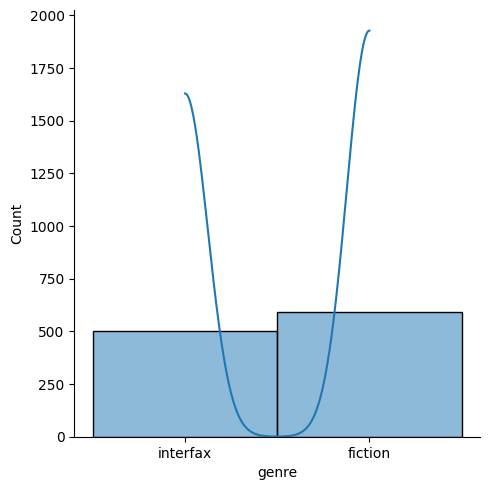

In [85]:
#Объединение двух похожих классов
df['genre'] = df['genre'].replace('kp', 'interfax')
#Проверка на сбалансированность
sns.displot(data=df, x = 'genre', kde = True)
#plt.show()

In [86]:
sw = stopwords.words(rus)
# добавил слово "это", "мочь", "свой", "который", "решить", "сказать"
sw += ["это", "мочь", "свой", "который", "решить", "сказать"]
sw

['и',
 'в',
 'во',
 'не',
 'что',
 'он',
 'на',
 'я',
 'с',
 'со',
 'как',
 'а',
 'то',
 'все',
 'она',
 'так',
 'его',
 'но',
 'да',
 'ты',
 'к',
 'у',
 'же',
 'вы',
 'за',
 'бы',
 'по',
 'только',
 'ее',
 'мне',
 'было',
 'вот',
 'от',
 'меня',
 'еще',
 'нет',
 'о',
 'из',
 'ему',
 'теперь',
 'когда',
 'даже',
 'ну',
 'вдруг',
 'ли',
 'если',
 'уже',
 'или',
 'ни',
 'быть',
 'был',
 'него',
 'до',
 'вас',
 'нибудь',
 'опять',
 'уж',
 'вам',
 'ведь',
 'там',
 'потом',
 'себя',
 'ничего',
 'ей',
 'может',
 'они',
 'тут',
 'где',
 'есть',
 'надо',
 'ней',
 'для',
 'мы',
 'тебя',
 'их',
 'чем',
 'была',
 'сам',
 'чтоб',
 'без',
 'будто',
 'чего',
 'раз',
 'тоже',
 'себе',
 'под',
 'будет',
 'ж',
 'тогда',
 'кто',
 'этот',
 'того',
 'потому',
 'этого',
 'какой',
 'совсем',
 'ним',
 'здесь',
 'этом',
 'один',
 'почти',
 'мой',
 'тем',
 'чтобы',
 'нее',
 'сейчас',
 'были',
 'куда',
 'зачем',
 'всех',
 'никогда',
 'можно',
 'при',
 'наконец',
 'два',
 'об',
 'другой',
 'хоть',
 'после',
 'на

In [87]:
#Y = #pd.DataFrame({'genre':[0 if genre == 'fiction' else 1 for genre in df['genre']]})
Y = pd.DataFrame({'genre':[str(genre) for genre in df['genre']]})
#Формирование наборов данных
df_morphy = pd.DataFrame({'text':[tokenize_morphy(sample) 
for sample in df['premise']]})
df_snowball = pd.DataFrame({'text':[tokenize_snowball(sample) 
for sample in df['premise']]})
df_lancaster = pd.DataFrame({'text':[tokenize_lancaster(sample) 
for sample in df['premise']]})
#Очистка от пустот
X1 = df_lancaster.dropna()
X2 = df_morphy.dropna()
X3 = df_snowball.dropna()
#формирование данных в виде "текст - класс"
batch1 = X1.join(Y, how = 'right')
batch2 = X2.join(Y, how = 'right')
batch3 = X3.join(Y, how = 'right')

In [ ]:
Y['genre'].unique()

array(['interfax', 'fiction'], dtype=object)

In [ ]:
STOPWORDS_ = sw

In [ ]:
#Разбиение на данные
X_train, X_test, y_train, y_test = train_test_split(batch2['text'], batch2['genre'], test_size = 0.2, random_state = 13)

In [ ]:
X_train

314    мой любимый покупка обувь  дух      терпеть  м...
99       материться   врать ловить  поличное неоднокр...
838    выходить  угадать  судьба   действительно съес...
865    назвать сборник  последний рассказ скроить  ре...
614       бывало снисхождение жалость  тепло человек ...
                             ...                        
866      всякий случай       возненавидеть   институт...
742     признать   совершить непозволительный ошибка ...
74      считать  пока  нужно торопиться  регистрация ...
176      начинать увлекаться кинематограф  раз  брать...
338    вина женщина признать частично мотив  совершен...
Name: text, Length: 876, dtype: object

In [ ]:
def score_report(y_test, pred):
    acc =       accuracy_score(y_test, pred)
    recall =    recall_score(y_test, pred, average="binary", pos_label="fiction")
    precision = precision_score(y_test, pred, average="binary", pos_label="fiction")
    f1score =  f1_score(y_test, pred, average="binary", pos_label="fiction")
    scores = pd.DataFrame({"Accuracy" : [acc], "Recall" : [recall], "Precision" : [precision], "f1score" : [f1score]})
    return scores

In [ ]:
# объявляем экземпляр класса CountVectorizer
# используем униграммы, то есть каждое слово отдельно
vec = CountVectorizer(ngram_range=(1, 2))
# формируем мешок слов на тренировочных данных, используем fit_transform
# для обучения векторизатора на тренировочных данных
bow = vec.fit_transform(X_train.values.astype('U')) 
# преобразуем тестовые данные в числовые векторы используя обученный векторизатор
bow_test = vec.transform(X_test)
# Используем MaxAbsScaler для приведения всех признаков к одинаковому масштабу
scaler = MaxAbsScaler() 
# обучаем масштабировщик на тренирвочных данных и преобразуем
bow = scaler.fit_transform(bow) 
# применяем обученный масштабировщик к тестовым данным
bow_test = scaler.transform(bow_test) 

# обучаем логистическую регрессию на масштабированных тренировочных данных
clf = LogisticRegression(max_iter=200, random_state=42)
clf.fit(bow, y_train)

# получаем предсказание на тестовых данных
pred = clf.predict(bow_test)
bow_features = [bow, bow_test,y_train,y_test]
# отчет о классификации с использованием разилчных метрик
score_report(y_test, pred)

,Accuracy,Recall,Precision,f1score
0,0.845455,0.946903,0.792593,0.862903


In [ ]:
#Разбиение на данные
X_train, X_test, y_train, y_test = train_test_split(batch2['text'], batch2['genre'], test_size = 0.2, random_state = 13)

In [ ]:
X_test

374    глубина колея указывать    транспортный средст...
279     привязать  сад  пойти пожалуйста   думать    ...
893     казаться главный источник  накопиться   недор...
955        утверждать   знать заранее   врать сказать...
948    пользователь спорить   цвет российский  францу...
                             ...                        
302       мочь забыть  помнить вообще   живой сигарет...
133      дать соврать    правда мечтать  старший брат...
980      жизнь натерпеться  идти  поликлиника   урод ...
690    представитель агентство заявить  расследование...
631     оставлять  сторона экономика проект   ресурсн...
Name: text, Length: 220, dtype: object

In [ ]:

# создаем объект класса TfidVectorizer, min_df = 5 означает, что слова, которые встречаются
# менее чем в 5% документов будут игнорироваться
# используем униграммы, то есть пословный анализ
# max_df = 1.0 означает, что слова, которые используются в каждом документе также игнорируются
tfidf = TfidfVectorizer(min_df = 5, max_df = 1.0, ngram_range = (1, 2))
# обучаем TfidfVectorizer на тренировочных данных
# определяем словарь признаков, для дальнейшего преобразования в векторы
tfidf.fit(X_train.values.astype('U'))
# преобразуем текстовые данные в числовые векторы
Xtrain = tfidf.transform(X_train.values.astype('U'))
Xtest = tfidf.transform(X_test.values.astype('U'))
# Обучаем классификатор логистическую регрессию
lr_clf = LogisticRegression(max_iter=300, random_state=42)
lr_clf.fit(Xtrain, y_train)

# делаем предсказания на тренировочных и тестовых данных
#lr_train_pred = lr_clf.predict(Xtrain)
pred = lr_clf.predict(Xtest)
tfidf_features = [Xtrain, Xtest, y_train, y_test]
score_report(y_test, pred)

,Accuracy,Recall,Precision,f1score
0,0.840909,0.938053,0.791045,0.8583


In [ ]:
#batch2.dropna()

In [ ]:
batch2.dropna()

,text,genre
0,сумма ущерб составить один тысяча рубль уточня...,interfax
1,перебрасываться словечко скользить глаз мой ...,fiction
2,сказать хотеть выпить кофе казаться ска...,fiction
3,зима показать характер,interfax
4,гуманность бог подобный сценарий предполагать...,fiction
...,...,...
1091,кто нужный нужно забрать сумасшедший дом о...,fiction
1092,равно любить сказать вернуться знат...,fiction
1093,слово помнить лишь собираться выйти дом ...,interfax
1094,допросить гость следователь восстановить карти...,interfax


In [ ]:
batch2 = batch2.dropna()
#batch2 = batch2.reset_index(drop=True)
#Разбиение на данные
X_train, X_test, y_train, y_test = train_test_split(batch2[['text']], batch2[['genre']], test_size = 0.2, random_state = 13)

In [ ]:
batch2.shape

(1096, 2)

In [ ]:
from gensim.models import Word2Vec
sent = [row.split() for row in X_train['text']]
HIDDEN = 100
model = Word2Vec(min_count=20,
                     window=2,
                     vector_size=HIDDEN,
                     sample=6e-5,
                     alpha=0.03,
                     min_alpha=0.0007,
                     negative=20,
                     workers=2)
model.build_vocab(sent, progress_per=10000)
model.train(sent, total_examples=model.corpus_count, epochs=30, report_delay=1)

(7022, 420960)

In [ ]:
#счет последнего вектора текста
def get_mean_w2v_vector(sentence):
    Sum = 0
    Count = 0

    try:
      words = sentence.split()
    except TypeError:
      words = []

    for w in words:
        if w in model.wv:
            Sum += model.wv[w]
            # Sum += glove_vectors[w]
            Count += 1

    if Count == 0:
        return 0

    return Sum / Count

In [ ]:
NewCols = ['col'+str(i) for i in range(HIDDEN)]

X_train['vectors'] = X_train['text'].map(get_mean_w2v_vector)
X_test['vectors'] = X_test['text'].map(get_mean_w2v_vector)


In [ ]:
IdxTrain = []

for ix, row in X_train.iterrows():
    if not isinstance(row['vectors'],np.ndarray):
        IdxTrain.append(ix)

IdxTest = []

for ix, row in X_test.iterrows():
    if not isinstance(row['vectors'],np.ndarray):
        IdxTest.append(ix)

In [ ]:
X_train.drop(index=IdxTrain, inplace=True)
X_test.drop(index=IdxTest, inplace=True)

y_train = y_train.drop(index=IdxTrain)
y_test = y_test.drop(index=IdxTest)

In [ ]:
y_test.shape

(211, 1)

In [ ]:
X_test.shape

(211, 2)

In [ ]:
X_train[NewCols] = pd.DataFrame(X_train['vectors'].tolist(), index=X_train.index)
X_test[NewCols] = pd.DataFrame(X_test['vectors'].tolist(), index=X_test.index)

In [ ]:
X_train.drop(['text','vectors'], axis=1, inplace=True)
X_test.drop(['text','vectors'], axis=1, inplace=True)

In [ ]:
X_train.head()

,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,...,col90,col91,col92,col93,col94,col95,col96,col97,col98,col99
314,0.002327,0.020931,-0.013729,-0.005039,0.024749,-0.051556,0.016923,0.071068,-0.027124,-0.046279,...,0.073164,0.001517,0.010386,0.018648,0.051265,0.012781,-0.015563,-0.031022,-0.015556,-0.006975
99,-0.001131,0.010565,-0.009961,-0.003586,0.019459,-0.036898,0.009203,0.054837,-0.014875,-0.027572,...,0.050971,0.002586,0.010215,0.009182,0.044463,0.009783,-0.009186,-0.018976,-0.009598,-0.013722
838,-0.000011,0.011377,-0.004541,0.001852,0.013260,-0.042153,0.014018,0.057753,-0.019036,-0.031914,...,0.054160,0.004188,0.007920,0.007378,0.046345,0.011265,-0.019990,-0.027370,-0.010612,-0.006004
865,-0.005707,0.018554,-0.009790,-0.000206,0.021767,-0.046103,0.010842,0.067095,-0.026702,-0.035186,...,0.070708,0.004080,0.010881,0.012975,0.052848,0.017511,-0.020068,-0.031125,-0.014901,-0.011647
614,-0.006509,0.031210,-0.020666,-0.002056,0.038584,-0.066650,0.018644,0.104886,-0.049636,-0.053370,...,0.102843,0.012356,0.025287,0.014963,0.089378,0.024591,-0.020101,-0.049316,-0.009902,-0.026391


In [ ]:
W2v_features = [X_train, X_test, y_train ,y_test]

In [ ]:
#X_train, X_test, y_train, y_test = W2v_features#W2V
#X_train, X_test, y_train, y_test = bow_features#BOW
X_train, X_test, y_train, y_test = tfidf_features#Tf-idf

In [ ]:
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)

#lr_train_pred = lr_clf.predict(X_train)
pred = lr_clf.predict(X_test)
#попробовать на своих примерах
#(0.5509138381201044, 0.5197568389057751)
score_report(y_test, pred)

,Accuracy,Recall,Precision,f1score
0,0.840909,0.938053,0.791045,0.8583


In [ ]:
svc = SVC()
svc.fit(X_train, y_train)
pred = svc.predict(X_test)
score_report(y_test, pred)

,Accuracy,Recall,Precision,f1score
0,0.831818,0.920354,0.787879,0.84898


In [ ]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
pred = gbc.predict(X_test)
score_report(y_test, pred)

,Accuracy,Recall,Precision,f1score
0,0.777273,0.893805,0.731884,0.804781


In [ ]:
abc = AdaBoostClassifier()
abc.fit(X_train, y_train)
pred = abc.predict(X_test)
score_report(y_test, pred)

,Accuracy,Recall,Precision,f1score
0,0.718182,0.716814,0.72973,0.723214


In [ ]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
pred = rfc.predict(X_test)
score_report(y_test, pred)

,Accuracy,Recall,Precision,f1score
0,0.822727,0.929204,0.772059,0.843373


In [ ]:
knc = KNeighborsClassifier()
knc.fit(X_train, y_train)
pred = knc.predict(X_test)
score_report(y_test, pred)

,Accuracy,Recall,Precision,f1score
0,0.713636,0.973451,0.647059,0.777385


In [ ]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
pred = dtc.predict(X_test)
score_report(y_test, pred)

,Accuracy,Recall,Precision,f1score
0,0.75,0.761062,0.754386,0.757709


In [ ]:
text1 = "В архиве обнаружились данные об офшорах и зарубежных фирмах должностных лиц России или членов их семей, а также о компаниях, бенефициарами которых являются близкие друзья"
text2 = "Сам Белых не признал обвинения, заявив, что эти деньги должны были пойти на нужды Кирова. Следствие продолжается, Белых отправлен в отставку и находится в СИЗО."
text3 = "И Мишка схватил мой самосвал и побежал домой. А я остался со своим светлячком, глядел на него, глядел и никак не мог наглядеться: какой он зелёный, словно в сказке, и как он хоть и близко, на ладони, а светит, словно издалека… И я не мог ровно дышать, и я слышал, как стучит моё сердце, и чуть-чуть кололо в носу, как будто хотелось плакать."
text4 = "У меня в табеле одни пятёрки. Только по чистописанию четвёрка. Из-за клякс. Я прямо не знаю, что делать! У меня всегда с пера соскакивают кляксы. Я уж макаю в чернила только самый кончик пера, а кляксы всё равно соскакивают."
own_df = pd.DataFrame({'text' :[tokenize_morphy(t) for t in [text1, text2, text3, text4]]})
series = own_df['text']
own_test = tfidf.transform(series)
lr_clf.predict(own_test)
#own_test

array(['interfax', 'interfax', 'fiction', 'fiction'], dtype=object)